# main vs hardcoded variables and such that are used in all the scripts?
# methane_definitions ?

# Run the file containing the functions used in this script
## By default this is a file called "methane_functions.r" in the working directory of this script
## Do NOT change the working directory at any point while using this script.

In [3]:
methaneFunctions<-paste(getwd(),"/methane_functions.r",sep="")
methaneFunctions
if (file.exists(methaneFunctions)){
    source(methaneFunctions)
} else {
    print("manually correct the location and/or name of methane_functions.r")
}

[1] "/home/pleocavee/Documents/github/SensorDataProcessing/rriv_methane/methane_functions.r"

# 0. Load packages used

In [4]:
# Package names
packages <- c("dplyr", "doBy", "lubridate", "ggplot2", "Hmisc", "zoo", "viridis")
packageHandler(packages)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘doBy’


The following object is masked from ‘package:dplyr’:

    order_by



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: lattice

Loading required package: survival

Loading required package: Formula


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following objects are masked from ‘package:base’:

    format.pval, units



Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: viridisLite



# 1. Hardcoded definitions that don't require loading anything?

#### Hardcoded dictionary of column variables to plot and axis labels

# 2. Definitions that lead to or require processing data

### Location of data

In [5]:
#directory<-"/Users/jhosen/Library/CloudStorage/GoogleDrive-jakehosen@gmail.com/My Drive/WaterBear/CH4DHT22/20221110_pull/bin"
# directory<-"~/Desktop/data/mesoBinTests/20221110_pull"
# directory<-"~/Desktop/data/mesoBinTests/20221118_pull"
# directory<-"~/Desktop/data/mesoBinTests/20221127_pull"
# directory<-"~/Desktop/data/mesoBinTests/20221205_pull"
# directory<-"~/Desktop/data/mesoBinTests/20221214_pull"
# directory<-"~/Desktop/data/mesoBinTests/20221216_Experiment/RRIV"
# directory<-"~/Desktop/data/mesoBinTests//20230106_pull"
# directory<-"~/Desktop/data/mesoBinTests/20230111_floatingbucket"
# directory<-"~/Desktop/data/20230111_bench"

# directory<-"~/Desktop/data/mesoBinTests/20230118_floatingbucket/RRIV" #didn't have enough data here
# directory<-"~/Desktop/data/mesoBinTests/20230119_floatingbucket/RRIV"
# directory<-"~/Desktop/data/mesoBinTests/20230126_floatingbucket/RRIV"

# directory<-"~/Desktop/data/mesoBinTests/20230201_pull"
# directory<-"~/Desktop/data/mesoBinTests/20230203_pull"

## V0 tests with gas analyzer
# directory<-"~/Desktop/data/Methane Calibration/V0_tests/20230202_calibration_70F/RRIV"
# directory<-"~/Desktop/data/Methane Calibration/V0_tests/20230203_calibration_4C/RRIV"
# directory<-"~/Desktop/data/Methane Calibration/V0_tests/20230206_calibration_room/RRIV"
# directory<-"~/Desktop/data/Methane Calibration/V0_tests/20230207_calibration_93F/RRIV"
# directory<-"~/Desktop/data/Methane Calibration/V0_tests/20230209_cal_ignore_roomAir/RRIV"
# directory<-"~/Desktop/data/Methane Calibration/V0_tests/20230210_calibration_roomAir/RRIV"

## concentration tests with gas samples for GC
# directory<-"~/Desktop/data/Methane Calibration/concentration_tests/20230220_1000ppm_20230221_1210/RRIV"
# directory<-"~/Desktop/data/Methane Calibration/concentration_tests/20230221_100ppm_20230222_1330/RRIV"
# directory<-"~/Desktop/data/Methane Calibration/concentration_tests/20230222_20ppm_20230223_1130/RRIV"
# directory<-"~/Desktop/data/Methane Calibration/concentration_tests/20230223_10ppm_202230224_1139/RRIV"
# directory<-"~/Desktop/data/Methane Calibration/concentration_tests/20230224_5ppm_20230225_1150/RRIV"
# directory<-"~/Desktop/data/Methane Calibration/concentration_tests/20230225_1000ppm_20230227_1115/RRIV"

## dissipation test preliminary pull
# directory<-"~/Desktop/data/Methane Calibration/20230227_1000ppm_2ppm_dissipation/RRIV"
directory<-"~/Desktop/data/Methane Calibration/20230227_1000ppm-2ppm_dissipation/RRIV"

## Create global directory for outputs based on data directory
1. recognize sub folders (RRIV, Gas Analyzer, and GC) and create separate output folders?
2. split code between working on one set of data at a time, and code defines output based on that?

In [6]:
outputDir<-paste(directory,"_output/",sep="")
newDir(outputDir)

Output directory, ~/Desktop/data/Methane Calibration/20230227_1000ppm-2ppm_dissipation/RRIV_output/, already exists


# Read raw data into dataframe, get unique id values, process for measurementCycle and burstCycle if necessary

In [7]:
full_data<-concat_dirs(directory, read_rriv_CSV, minFileSize=300)
full_data<-process_rriv_columns(full_data)


loggerList<-unique(full_data$logger) #save each individual logger
loggerList

loggerCount<-length(loggerList) #how many loggers
loggerCount

# for measurementCycle and burstCycle, not necessary with updated firmware
processed_data<-parseIndividualLoggers(full_data)

[1] "Dataframe generated, manually process column types if necessary"


[1] 21010 21011 kcdev 21012 21013 21001
Levels: 21001 21010 21011 21012 21013 kcdev

[1] 6

## Specific processing depending on data

In [8]:
# This data had a timestamp issue on measurement cycle 51 to 52, first change in day from 12-01 to 12-02, for all data loggers
# add 1 day's worth of seconds to all data after that point to correct (1*24*60*60)
if(basename(directory)=="20221205_pull"){
    processed_data$time.s<-ifelse(processed_data$measurementCycle>51, processed_data$time.s+86400, processed_data$time.s)
    processed_data$time.h<-lubridate::as_datetime(processed_data$time.s)
}

## Save processed dataframe as .rds and .csv to output folder#

In [9]:
saveDFrds(processed_data)
saveDFcsv(processed_data)

[1] "~/Desktop/data/Methane Calibration/20230227_1000ppm-2ppm_dissipation/RRIV_output/processed_data.rds"
[1] "~/Desktop/data/Methane Calibration/20230227_1000ppm-2ppm_dissipation/RRIV_output/processed_data.csv"


## Split data set between "raw" and "summary" line types

In [10]:
raw_processed_data<-subset(processed_data, type=="raw")
summary_processed_data<-subset(processed_data, type=="summary")

In [15]:
str(summary_processed_data)

'data.frame':	15504 obs. of  19 variables:
 $ type            : Factor w/ 2 levels "raw","summary": 2 2 2 2 2 2 2 2 2 2 ...
 $ site            : Factor w/ 6 levels "C1","C2","C3",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ logger          : Factor w/ 6 levels "21001","21010",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ deployment      : Factor w/ 6 levels "calCH001-57FF70068387575129270167-1677514287",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ deployed_at     : int  1677514287 1677514287 1677514287 1677514287 1677514287 1677514287 1677514287 1677514287 1677514287 1677514287 ...
 $ uuid            : Factor w/ 6 levels "50FF6C068678545210222467",..: 5 5 5 5 5 5 5 5 5 5 ...
 $ time.s          : num  1.68e+09 1.68e+09 1.68e+09 1.68e+09 1.68e+09 ...
 $ time.h          : POSIXct, format: "2023-02-27 20:00:27" "2023-02-27 20:01:27" ...
 $ battery.V       : num  1062 926 1631 923 1628 ...
 $ measurementCycle: num  4 4 4 4 4 4 4 4 4 4 ...
 $ burstCycle      : Factor w/ 60 levels "1","2","3","4",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ dht_C 

In [11]:
variableDict<-getDict(raw_processed_data)

variableCount<-length(variableDict)
variableKeys<-names(variableDict)

In [20]:
all_summary<-plot_Data_v_Time(summary_processed_data,color="site")
savePlotList(all_summary)

In [13]:
range(summary_processed_data$time.h)

[1] "2023-02-27 20:00:26 UTC" "2023-03-01 15:03:27 UTC"

In [18]:
startTime<-lubridate::as_datetime("2023-02-27 20:00:26 UTC")
endTime<-startTime+1*60*60

subset_spd<-summary_processed_data[ summary_processed_data$time.h>startTime &
                                  summary_processed_data$time.h<endTime ,]

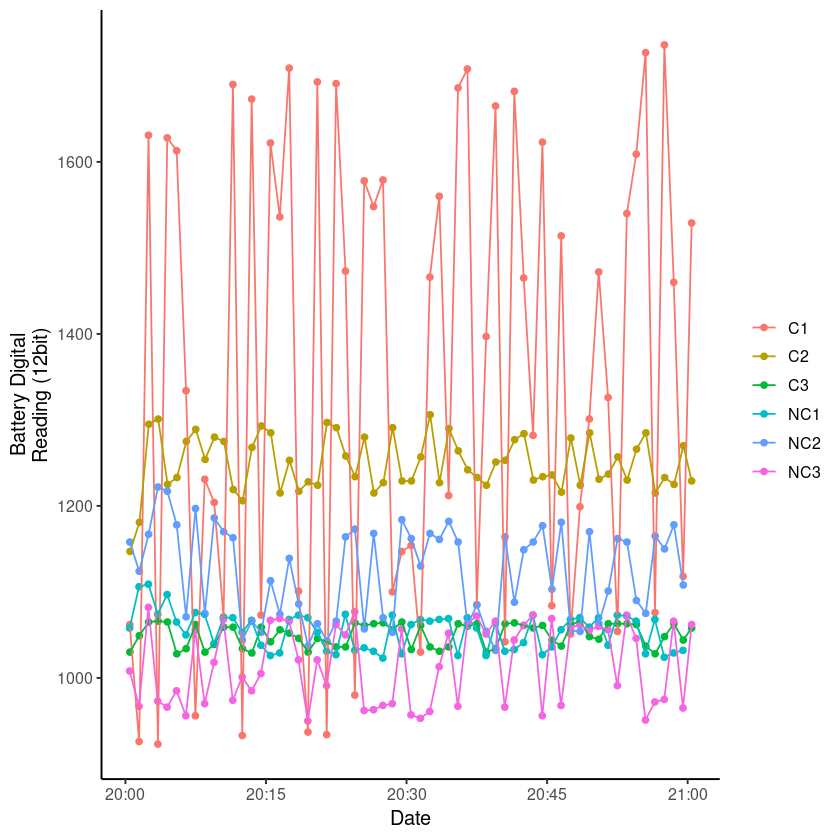

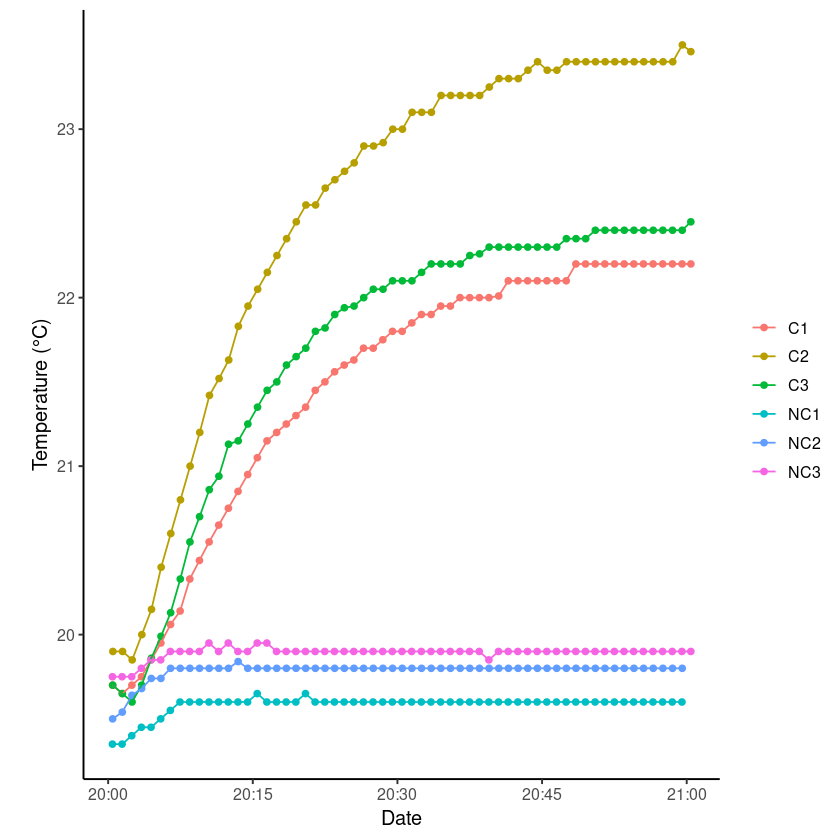

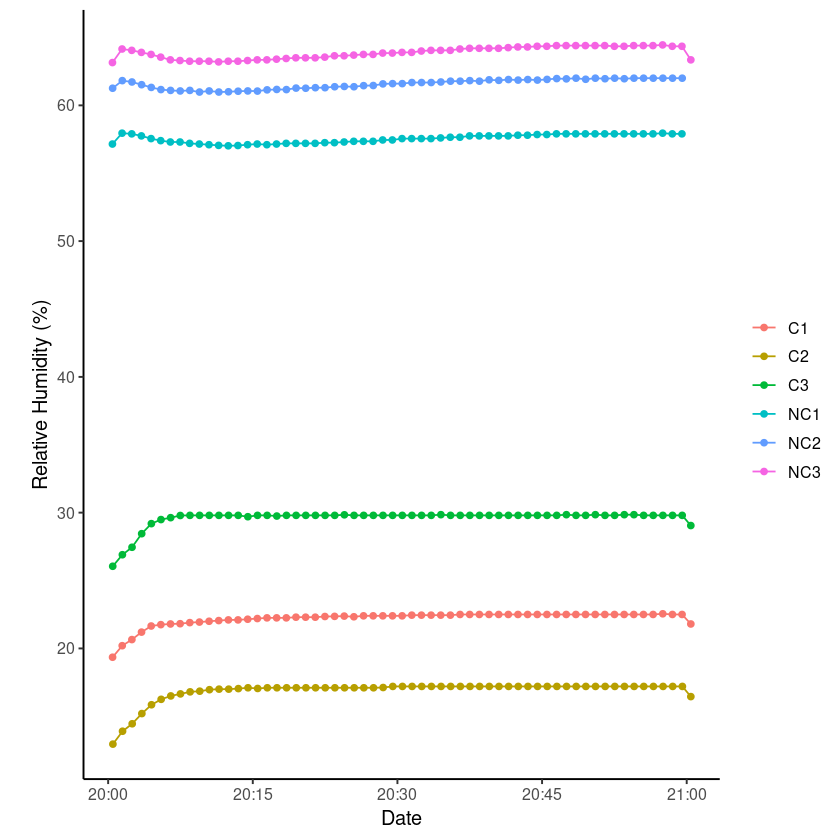

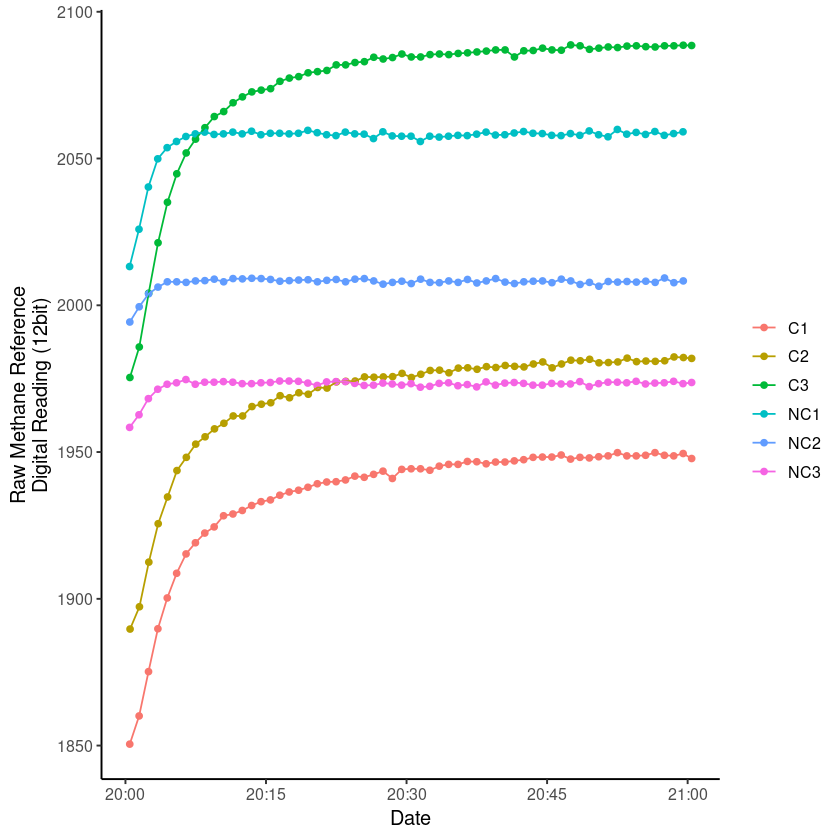

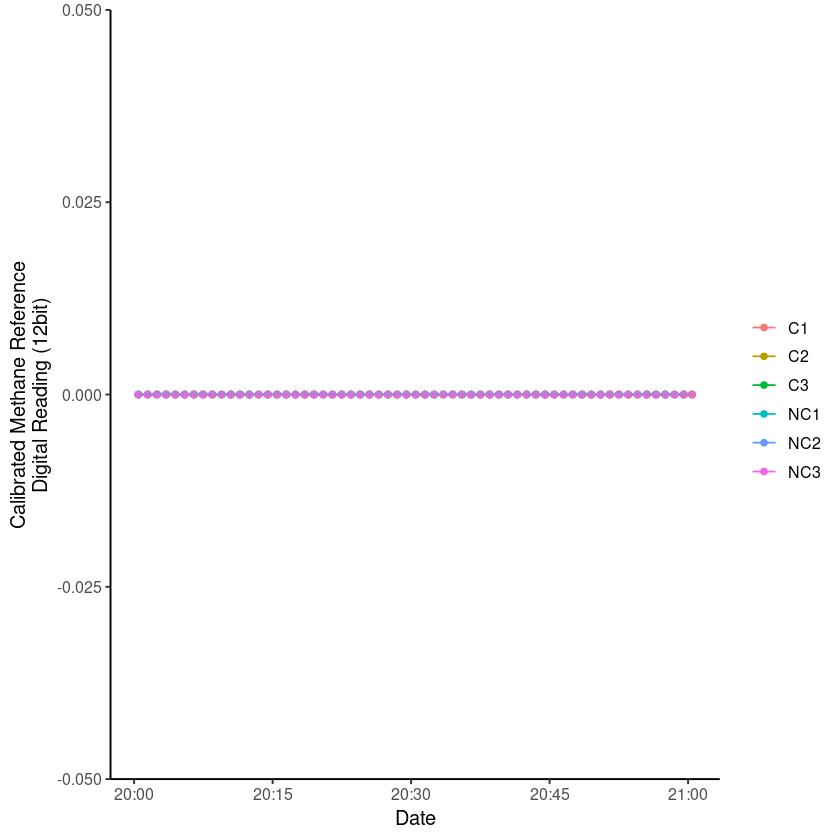

$battery.V

$dht_C

$dht_RH

$ch4rf_raw

$ch4rf_cal

$ch4_raw

$ch4_cal


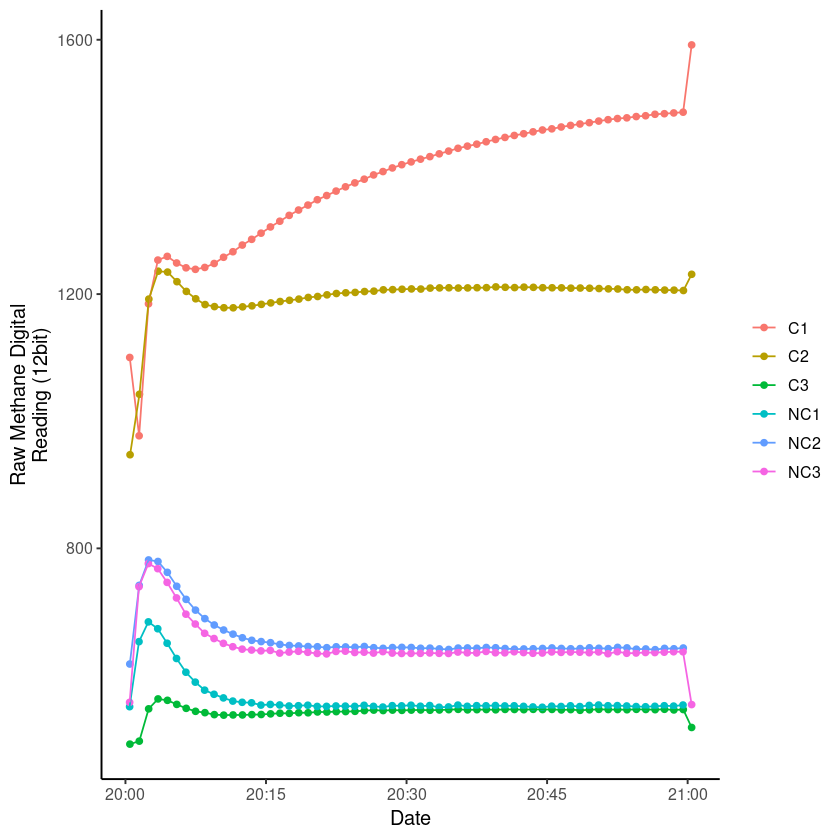

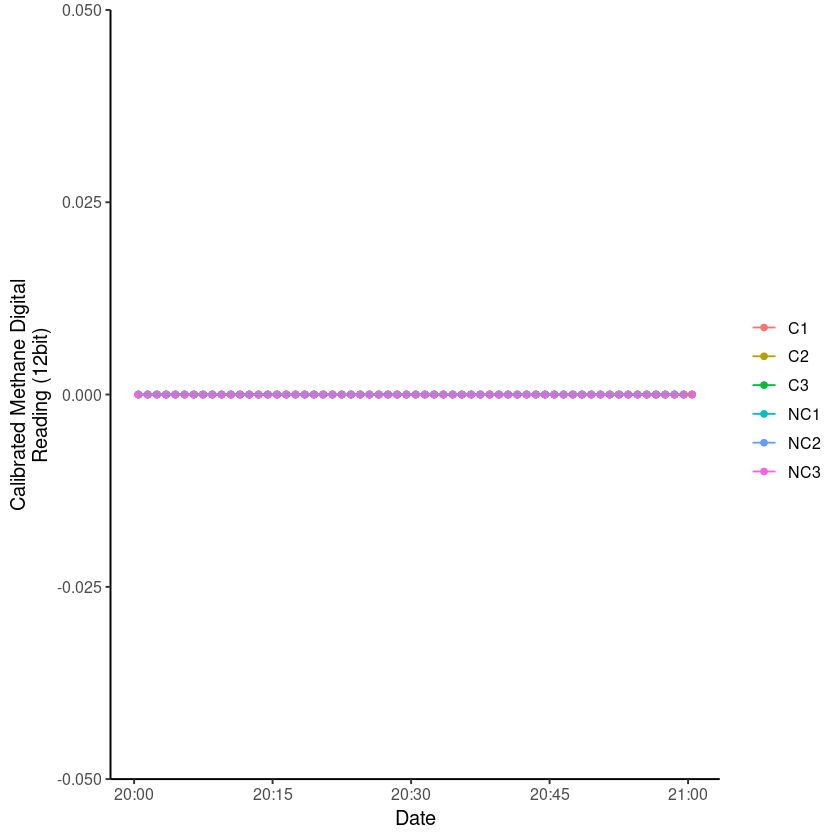

In [19]:
plot_Data_v_Time(subset_spd,color="site")